In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import xgboost as xgb
import lightgbm as lgbm
import catboost
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from category_encoders import LeaveOneOutEncoder
import optuna

In [2]:
from warnings import filterwarnings
filterwarnings("ignore")

#### NOTE:
If you want to see more insights and EDA, checkout this excellent [notebook](https://www.kaggle.com/code/craigmthomas/play-s3e8-eda-models) by Craig Thomas.

# Loading Data

In [3]:
BASE_PATH = Path("/kaggle/input/playground-series-s3e8")
train = pd.read_csv(BASE_PATH / "train.csv").drop(columns="id")
test = pd.read_csv(BASE_PATH  / "test.csv")
test_idx = test.id
test = test.drop(columns="id")

# Craig Thomas has shown in his excellent ntoebook that the original dataset is pretty similar to the compeition's one
# The notebook is linked above

original = pd.read_csv("/kaggle/input/gemstone-price-prediction/cubic_zirconia.csv").drop(columns="Unnamed: 0")

print(f"Loaded train with {len(train)} rows.")
print(f"Loaded test with {len(test)} rows.")
print(f"Loaded original with {len(original)} rows.")

Loaded train with 193573 rows.
Loaded test with 129050 rows.
Loaded original with 26967 rows.


Ha! the original contains only 27K rows or 1/4the of the train size. Not sure how much of a boost it will provide but for now let's just stick with the competition dataset.

In [4]:
all_datasets = {"train": train,
               "test": test,
               "original": original}

# Checking for Null values

In [5]:
pd.concat([dataset.isnull().sum().rename(f"Missing in {dataset_name}") 
               for dataset_name, dataset in all_datasets.items()],
                 axis=1)

,Missing in train,Missing in test,Missing in original
carat,0,0.0,0
cut,0,0.0,0
color,0,0.0,0
clarity,0,0.0,0
depth,0,0.0,697
table,0,0.0,0
x,0,0.0,0
y,0,0.0,0
z,0,0.0,0
price,0,NaN,0


## INSIGHTS: 
original contains 697 missing values, which we'll simnply drop

In [6]:
original.dropna(axis=0, how="any", inplace=True)

# Identifying categorical features

In [7]:
pd.concat([train.dtypes.rename("Data Type")] + \
          [dataset.nunique().rename(f"{dataset_name} UniqueValues") for dataset_name, dataset in all_datasets.items()],
          axis=1).sort_values(by="train UniqueValues")

,Data Type,train UniqueValues,test UniqueValues,original UniqueValues
cut,object,5,5.0,5
color,object,7,7.0,7
clarity,object,8,8.0,8
table,float64,108,101.0,112
depth,float64,153,143.0,169
carat,float64,248,252.0,256
z,float64,349,342.0,354
y,float64,521,516.0,525
x,float64,522,521.0,530
price,int64,8738,NaN,8629


In [8]:
cat_features = ["cut", "color", "clarity"]

Leveraging the feature descriptions from this [discussion](https://www.kaggle.com/competitions/playground-series-s3e8/discussion/389213) we will encode the above categorical values

### Encoding Cut
Describe the cut quality of the cubic zirconia. Quality is increasing order Fair, Good, Very Good, Premium, Ideal

In [9]:
cut_labels = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
cut_labels_map = {label: rank for rank, label in enumerate(cut_labels)}
cut_labels_map

{'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}

### Encoding Color
Colour of the cubic zirconia.With D being the best and J the worst.

In [10]:
color_labels = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
color_labels_map = {label: rank for rank, label in enumerate(reversed(color_labels))}
color_labels_map

{'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6}

### Encoding Clarity feature

In [11]:
clarity_labels = ['FL', 'IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1', 'I2', 'I3']
clarity_labels_map = {label: rank for rank, label in enumerate(reversed(clarity_labels))}
clarity_labels_map

{'I3': 0,
 'I2': 1,
 'I1': 2,
 'SI2': 3,
 'SI1': 4,
 'VS2': 5,
 'VS1': 6,
 'VVS2': 7,
 'VVS1': 8,
 'IF': 9,
 'FL': 10}

In [12]:
for dataset in all_datasets.values():
    dataset["cut"] = dataset["cut"].map(cut_labels_map)
    dataset["color"] = dataset["color"].map(color_labels_map)    
    dataset["clarity"] = dataset["clarity"].map(clarity_labels_map)    

# Preprocessing

In [13]:
X = train.drop(columns="price")
y = train.price

# Setting up feat importance plot

In [14]:
# def plot_feature_importances(feature_names, feature_importances):
#     fig = plt.figure(figsize = (15, 0.35*len(feature_importances)))
#     feature_imp_df = pd.DataFrame(data=zip(feature_names, feature_importances), columns=["feature", "importance"]).sort_values(by="importance", ascending=False)
#     plt.title('Feature importances', size=25, y=1.05)
#     sns.barplot(data=feature_imp_df, x='importance', y='feature')
#     plt.show()

# Setting Up Cross Validation

In [15]:
# def cross_validate(X, y):
#     N_FOLDS = 5
#     cv_scores = np.zeros(N_FOLDS)
#     kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=1337)
#     feature_importances_all_folds = np.zeros(shape=(N_FOLDS, len(X.columns)))
#     feature_names = X.columns
    
#     for fold_id, (train_idx, val_idx) in enumerate(kf.split(X)):
#         X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
#         X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
#         model = lgbm.LGBMRegressor()
#         model.fit(X_train, y_train,
#                      eval_set=[(X_val, y_val)],
#                      eval_metric="rmse",
#                      early_stopping_rounds=50,
#                      verbose=-1)
        
#         y_preds = model.predict(X_val)
        
#         feature_importances_all_folds[fold_id] = model.feature_importances_
        
#         rmse = mean_squared_error(y_val, y_preds, squared=False)
#         cv_scores[fold_id] = rmse
        
#         print(f"Fold {fold_id} | rmse: {rmse}")
    
#     avg_rmse = np.mean(cv_scores)
#     print(f"Avg RMSE across folds: {avg_rmse}")
    
#     avg_feature_importances = np.mean(feature_importances_all_folds, axis=0)
#     plot_feature_importances(feature_names, avg_feature_importances)

Fold 0 | rmse: 562.9377075715311
Fold 1 | rmse: 562.6182229269959
Fold 2 | rmse: 592.0190753235149
Fold 3 | rmse: 590.8050806000434
Fold 4 | rmse: 570.6389904127958
Avg RMSE across folds: 575.8038153669762


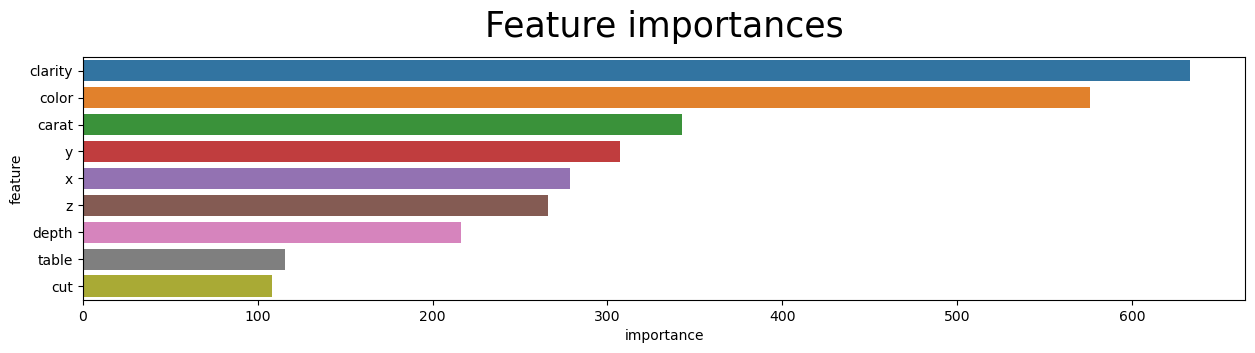

In [16]:
# cross_validate(X, y)

In [26]:
# def objective_xgb(trial, X, y):
#     params = {
#         'tree_method': "gpu_hist",
#         'n_estimators': trial.suggest_int('n_estimators', 50, 500),
#         'max_depth': trial.suggest_int('max_depth', 2, 20),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
#         'gamma': trial.suggest_loguniform('gamma', 0.00001, 0.3),
#         'subsample': trial.suggest_categorical('subsample', [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
#         'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
#         'early_stopping_rounds': trial.suggest_int("early_stoppig_rounds", 40, 100)
#     }
#     # we're gonna train on the combined dataset but, we'll only calculate the validation score only on comp data

#     N_FOLDS = 5
#     all_scores = np.zeros(N_FOLDS)

#     skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=1337)

#     for fold_id, (train_idx, val_idx) in enumerate(skf.split(X)):
        
#         X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
#         model = xgb.XGBRegressor(**params)
#         model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        
#         y_pred = model.predict(X_val)
                
#         rmse = mean_squared_error(y_val, y_pred, squared=False)        
#         all_scores[fold_id] = rmse
    
#     avg_rmse = np.mean(all_scores)
    
#     print(f"Avg RMSE: {avg_rmse}")
    
#     return avg_rmse

# study_xgb = optuna.create_study(study_name="xgboost_tuning", direction="minimize")
# func = lambda trial: objective_xgb(trial, X, y)
# study_xgb.optimize(func, n_trials=30)

[I 2023-02-21 07:40:49,353] A new study created in memory with name: xgboost_tuning
[I 2023-02-21 07:40:57,085] Trial 0 finished with value: 582.5618518678477 and parameters: {'n_estimators': 481, 'max_depth': 9, 'learning_rate': 0.17294009844046346, 'min_child_weight': 3, 'gamma': 3.836371552349043e-05, 'subsample': 1.0, 'colsample_bytree': 0.6, 'early_stoppig_rounds': 45}. Best is trial 0 with value: 582.5618518678477.


Avg RMSE: 582.5618518678477


[I 2023-02-21 07:41:37,516] Trial 1 finished with value: 670.6984207196355 and parameters: {'n_estimators': 177, 'max_depth': 17, 'learning_rate': 0.19235446251356053, 'min_child_weight': 4, 'gamma': 7.655111825011224e-05, 'subsample': 0.2, 'colsample_bytree': 0.3, 'early_stoppig_rounds': 49}. Best is trial 0 with value: 582.5618518678477.


Avg RMSE: 670.6984207196355


[I 2023-02-21 07:42:26,705] Trial 2 finished with value: 1007.174740210475 and parameters: {'n_estimators': 123, 'max_depth': 19, 'learning_rate': 0.017242071348517653, 'min_child_weight': 8, 'gamma': 0.00955159848565054, 'subsample': 0.6, 'colsample_bytree': 0.5, 'early_stoppig_rounds': 45}. Best is trial 0 with value: 582.5618518678477.


Avg RMSE: 1007.174740210475


[I 2023-02-21 07:42:44,202] Trial 3 finished with value: 581.2765589544891 and parameters: {'n_estimators': 78, 'max_depth': 11, 'learning_rate': 0.08678085655422997, 'min_child_weight': 3, 'gamma': 0.07162660851226352, 'subsample': 0.5, 'colsample_bytree': 0.7, 'early_stoppig_rounds': 96}. Best is trial 3 with value: 581.2765589544891.


Avg RMSE: 581.2765589544891


[I 2023-02-21 07:42:48,721] Trial 4 finished with value: 579.510515216163 and parameters: {'n_estimators': 386, 'max_depth': 4, 'learning_rate': 0.03289464957460058, 'min_child_weight': 11, 'gamma': 0.004978917220917844, 'subsample': 1.0, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 44}. Best is trial 4 with value: 579.510515216163.


Avg RMSE: 579.510515216163


[I 2023-02-21 07:42:54,099] Trial 5 finished with value: 947.9592151891081 and parameters: {'n_estimators': 179, 'max_depth': 8, 'learning_rate': 0.08142105086616334, 'min_child_weight': 1, 'gamma': 0.051805919592916534, 'subsample': 0.6, 'colsample_bytree': 0.2, 'early_stoppig_rounds': 82}. Best is trial 4 with value: 579.510515216163.


Avg RMSE: 947.9592151891081


[I 2023-02-21 07:42:58,262] Trial 6 finished with value: 584.0517999167539 and parameters: {'n_estimators': 345, 'max_depth': 4, 'learning_rate': 0.12449939357720692, 'min_child_weight': 13, 'gamma': 1.0935045383221037e-05, 'subsample': 0.6, 'colsample_bytree': 0.5, 'early_stoppig_rounds': 76}. Best is trial 4 with value: 579.510515216163.


Avg RMSE: 584.0517999167539


[I 2023-02-21 07:43:23,982] Trial 7 finished with value: 585.0709229050044 and parameters: {'n_estimators': 193, 'max_depth': 11, 'learning_rate': 0.061157193542317, 'min_child_weight': 9, 'gamma': 0.00010240775824272139, 'subsample': 0.3, 'colsample_bytree': 0.5, 'early_stoppig_rounds': 46}. Best is trial 4 with value: 579.510515216163.


Avg RMSE: 585.0709229050044


[I 2023-02-21 07:44:36,949] Trial 8 finished with value: 670.6485681918717 and parameters: {'n_estimators': 122, 'max_depth': 19, 'learning_rate': 0.04558951335008119, 'min_child_weight': 10, 'gamma': 1.0267427854528386e-05, 'subsample': 0.5, 'colsample_bytree': 0.4, 'early_stoppig_rounds': 57}. Best is trial 4 with value: 579.510515216163.


Avg RMSE: 670.6485681918717


[I 2023-02-21 07:44:46,828] Trial 9 finished with value: 869.6226571528498 and parameters: {'n_estimators': 101, 'max_depth': 10, 'learning_rate': 0.02403039693935869, 'min_child_weight': 9, 'gamma': 0.002194614410491834, 'subsample': 0.2, 'colsample_bytree': 0.5, 'early_stoppig_rounds': 84}. Best is trial 4 with value: 579.510515216163.


Avg RMSE: 869.6226571528498


[I 2023-02-21 07:44:49,629] Trial 10 finished with value: 864.4044815715645 and parameters: {'n_estimators': 372, 'max_depth': 2, 'learning_rate': 0.012913431161834665, 'min_child_weight': 15, 'gamma': 0.0007583746337683847, 'subsample': 1.0, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 63}. Best is trial 4 with value: 579.510515216163.


Avg RMSE: 864.4044815715645


[I 2023-02-21 07:46:28,441] Trial 11 finished with value: 580.7465801766235 and parameters: {'n_estimators': 295, 'max_depth': 14, 'learning_rate': 0.036816714668715625, 'min_child_weight': 6, 'gamma': 0.12749579180844195, 'subsample': 0.5, 'colsample_bytree': 0.7, 'early_stoppig_rounds': 100}. Best is trial 4 with value: 579.510515216163.


Avg RMSE: 580.7465801766235


[I 2023-02-21 07:49:14,774] Trial 12 finished with value: 583.7708019487862 and parameters: {'n_estimators': 298, 'max_depth': 15, 'learning_rate': 0.03433732360298819, 'min_child_weight': 7, 'gamma': 0.2751171733268762, 'subsample': 0.9, 'colsample_bytree': 0.7, 'early_stoppig_rounds': 96}. Best is trial 4 with value: 579.510515216163.


Avg RMSE: 583.7708019487862


[I 2023-02-21 07:51:17,347] Trial 13 finished with value: 581.1744172575724 and parameters: {'n_estimators': 436, 'max_depth': 14, 'learning_rate': 0.030922257128866558, 'min_child_weight': 6, 'gamma': 0.012117138852288437, 'subsample': 0.7, 'colsample_bytree': 0.8, 'early_stoppig_rounds': 66}. Best is trial 4 with value: 579.510515216163.


Avg RMSE: 581.1744172575724


[I 2023-02-21 07:51:23,965] Trial 14 finished with value: 574.202568951317 and parameters: {'n_estimators': 270, 'max_depth': 6, 'learning_rate': 0.022156986813172946, 'min_child_weight': 12, 'gamma': 0.29452812436197673, 'subsample': 0.4, 'colsample_bytree': 0.9, 'early_stoppig_rounds': 88}. Best is trial 14 with value: 574.202568951317.


Avg RMSE: 574.202568951317


[I 2023-02-21 07:51:33,494] Trial 15 finished with value: 584.043451627355 and parameters: {'n_estimators': 395, 'max_depth': 6, 'learning_rate': 0.010981487200449192, 'min_child_weight': 12, 'gamma': 0.28410547642227535, 'subsample': 0.4, 'colsample_bytree': 0.9, 'early_stoppig_rounds': 87}. Best is trial 14 with value: 574.202568951317.


Avg RMSE: 584.043451627355


[I 2023-02-21 07:51:39,884] Trial 16 finished with value: 578.6180797845038 and parameters: {'n_estimators': 242, 'max_depth': 6, 'learning_rate': 0.0195923909391786, 'min_child_weight': 12, 'gamma': 0.0253105329512123, 'subsample': 0.4, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 74}. Best is trial 14 with value: 574.202568951317.


Avg RMSE: 578.6180797845038


[I 2023-02-21 07:51:49,026] Trial 17 finished with value: 600.6967330499741 and parameters: {'n_estimators': 241, 'max_depth': 7, 'learning_rate': 0.01487463410905981, 'min_child_weight': 15, 'gamma': 0.040740022277636755, 'subsample': 0.4, 'colsample_bytree': 0.9, 'early_stoppig_rounds': 74}. Best is trial 14 with value: 574.202568951317.


Avg RMSE: 600.6967330499741


[I 2023-02-21 07:51:53,377] Trial 18 finished with value: 584.6939709891257 and parameters: {'n_estimators': 257, 'max_depth': 5, 'learning_rate': 0.020392082134647077, 'min_child_weight': 13, 'gamma': 0.023038219583089777, 'subsample': 0.4, 'colsample_bytree': 0.9, 'early_stoppig_rounds': 87}. Best is trial 14 with value: 574.202568951317.


Avg RMSE: 584.6939709891257


[I 2023-02-21 07:51:55,441] Trial 19 finished with value: 1255.4533476901638 and parameters: {'n_estimators': 222, 'max_depth': 2, 'learning_rate': 0.010460599350996438, 'min_child_weight': 13, 'gamma': 0.13772394379255298, 'subsample': 0.8, 'colsample_bytree': 1.0, 'early_stoppig_rounds': 76}. Best is trial 14 with value: 574.202568951317.


Avg RMSE: 1255.4533476901638


[I 2023-02-21 07:52:06,361] Trial 20 finished with value: 571.8248604989445 and parameters: {'n_estimators': 307, 'max_depth': 7, 'learning_rate': 0.02203161362695808, 'min_child_weight': 11, 'gamma': 0.02592719675589613, 'subsample': 0.4, 'colsample_bytree': 0.8, 'early_stoppig_rounds': 91}. Best is trial 20 with value: 571.8248604989445.


Avg RMSE: 571.8248604989445


[I 2023-02-21 07:52:17,504] Trial 21 finished with value: 571.5297177694847 and parameters: {'n_estimators': 330, 'max_depth': 7, 'learning_rate': 0.023030279970183625, 'min_child_weight': 11, 'gamma': 0.021311142091100653, 'subsample': 0.4, 'colsample_bytree': 0.8, 'early_stoppig_rounds': 91}. Best is trial 21 with value: 571.5297177694847.


Avg RMSE: 571.5297177694847


[I 2023-02-21 07:52:33,451] Trial 22 finished with value: 571.5166555758672 and parameters: {'n_estimators': 326, 'max_depth': 8, 'learning_rate': 0.02406134227532192, 'min_child_weight': 11, 'gamma': 0.08686700543654916, 'subsample': 0.4, 'colsample_bytree': 0.8, 'early_stoppig_rounds': 92}. Best is trial 22 with value: 571.5166555758672.


Avg RMSE: 571.5166555758672


[I 2023-02-21 07:52:49,189] Trial 23 finished with value: 571.1882846673061 and parameters: {'n_estimators': 318, 'max_depth': 8, 'learning_rate': 0.024879652005578044, 'min_child_weight': 10, 'gamma': 0.015850652108025234, 'subsample': 0.4, 'colsample_bytree': 0.8, 'early_stoppig_rounds': 93}. Best is trial 23 with value: 571.1882846673061.


Avg RMSE: 571.1882846673061


[I 2023-02-21 07:53:11,866] Trial 24 finished with value: 572.0031894147781 and parameters: {'n_estimators': 340, 'max_depth': 9, 'learning_rate': 0.0267857390908632, 'min_child_weight': 10, 'gamma': 0.01060140707728571, 'subsample': 0.4, 'colsample_bytree': 0.8, 'early_stoppig_rounds': 93}. Best is trial 23 with value: 571.1882846673061.


Avg RMSE: 572.0031894147781


[I 2023-02-21 07:55:19,257] Trial 25 finished with value: 576.1699986108976 and parameters: {'n_estimators': 429, 'max_depth': 12, 'learning_rate': 0.014183229637898889, 'min_child_weight': 8, 'gamma': 0.06495224507598236, 'subsample': 0.7, 'colsample_bytree': 0.8, 'early_stoppig_rounds': 100}. Best is trial 23 with value: 571.1882846673061.


Avg RMSE: 576.1699986108976


[I 2023-02-21 07:55:30,269] Trial 26 finished with value: 571.5141877059601 and parameters: {'n_estimators': 328, 'max_depth': 8, 'learning_rate': 0.04652356489330836, 'min_child_weight': 10, 'gamma': 0.002896325406640177, 'subsample': 0.8, 'colsample_bytree': 0.8, 'early_stoppig_rounds': 81}. Best is trial 23 with value: 571.1882846673061.


Avg RMSE: 571.5141877059601


[I 2023-02-21 07:56:16,622] Trial 27 finished with value: 577.3417628620449 and parameters: {'n_estimators': 427, 'max_depth': 12, 'learning_rate': 0.04590728206871227, 'min_child_weight': 9, 'gamma': 0.004109593575861661, 'subsample': 0.8, 'colsample_bytree': 0.8, 'early_stoppig_rounds': 79}. Best is trial 23 with value: 571.1882846673061.


Avg RMSE: 577.3417628620449


[I 2023-02-21 07:56:32,450] Trial 28 finished with value: 572.2756091348708 and parameters: {'n_estimators': 359, 'max_depth': 9, 'learning_rate': 0.04379561354103304, 'min_child_weight': 14, 'gamma': 0.0006970484678085277, 'subsample': 0.8, 'colsample_bytree': 0.8, 'early_stoppig_rounds': 82}. Best is trial 23 with value: 571.1882846673061.


Avg RMSE: 572.2756091348708


[I 2023-02-21 07:56:38,452] Trial 29 finished with value: 595.5937936900889 and parameters: {'n_estimators': 473, 'max_depth': 9, 'learning_rate': 0.27845613082591675, 'min_child_weight': 10, 'gamma': 0.005634803864729545, 'subsample': 0.3, 'colsample_bytree': 0.6, 'early_stoppig_rounds': 95}. Best is trial 23 with value: 571.1882846673061.


Avg RMSE: 595.5937936900889


In [14]:
# def objective_cat(trial, X, y):
#     params = {
#         "task_type": "GPU",
#         "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
#         "loss_function": trial.suggest_categorical("loss_function", ["rmse"]),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 3e-1),
#         "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
#         "colsample_bylevel": trial.suggest_categorical("colsample_bylevel", [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
#         "depth": trial.suggest_int("depth", 1, 20),
#         "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#         "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
#         "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 50, 200)
#     }
#     # we're gonna train on the combined dataset but, we'll only calculate the validation score only on comp data

#     N_FOLDS = 5
#     all_scores = np.zeros(N_FOLDS)

#     skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=1337)

#     for fold_id, (train_idx, val_idx) in enumerate(skf.split(X)):
        
#         X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
#         model = xgb.XGBRegressor(**params)
#         model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        
#         y_pred = model.predict(X_val)
                
#         rmse = mean_squared_error(y_val, y_pred, squared=False)        
#         all_scores[fold_id] = rmse
    
#     avg_rmse = np.mean(all_scores)
    
#     print(f"Avg RMSE: {avg_rmse}")
    
#     return avg_rmse

# study_cat = optuna.create_study(study_name="cat_tuning", direction="minimize")
# func = lambda trial: objective_cat(trial, X, y)
# study_cat.optimize(func, n_trials=30)

[I 2023-02-21 08:08:29,272] A new study created in memory with name: cat_tuning


[08:08:29] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting_type", "bootstrap_type", "depth", "l2_leaf_reg", "loss_function", "min_data_in_leaf", "task_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:09:34] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting_type", "bootstrap_type", "depth", "l2_leaf_reg", "loss_function", "min_data_in_leaf", "task_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:10:37] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting_type", "bootstrap_ty

[I 2023-02-21 08:13:45,544] Trial 0 finished with value: 573.007629460284 and parameters: {'n_estimators': 962, 'loss_function': 'rmse', 'learning_rate': 0.008152282233877622, 'l2_leaf_reg': 0.01867380592752931, 'colsample_bylevel': 0.8, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 4, 'early_stopping_rounds': 134}. Best is trial 0 with value: 573.007629460284.


Avg RMSE: 573.007629460284
[08:13:45] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting_type", "bootstrap_type", "depth", "l2_leaf_reg", "loss_function", "min_data_in_leaf", "task_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:15:02] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting_type", "bootstrap_type", "depth", "l2_leaf_reg", "loss_function", "min_data_in_leaf", "task_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[W 2023-02-21 08:16:09,970] Trial 1 failed with parameters: {'n_estimators': 998, 'loss_function': 'rmse', 'learning_rate': 0.003719428360057698, 'l2_leaf_reg': 0.2589704557463405, 'colsample_bylevel': 1.0, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 16, 'early_stopping_rounds': 63} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_28/3800644419.py", line 42, in <lambda>
    func = lambda trial: objective_cat(trial, X, y)
  File "/tmp/ipykernel_28/3800644419.py", line 28, in objective_cat
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 972, in fit
    callb

KeyboardInterrupt: 

In [24]:
# slighly tuned xgb params
xgb_params = {'n_estimators': 318, 'max_depth': 8, 'learning_rate': 0.024879652005578044, 
              'min_child_weight': 10, 'gamma': 0.015850652108025234,
            'subsample': 0.4, 'colsample_bytree': 0.8, 'early_stoppig_rounds': 93,
             "eval_metric": "rmse"}

# slightly tuned LGBM params
lgbm_params = {'n_estimators': 1827, 'num_rounds': 611, 'learning_rate': 0.13058858406970078, 
               'num_leaves': 150, 'max_depth': 8, 'min_data_in_leaf': 138, 'lambda_l1': 0.00029970392548376413, 
               'lambda_l2': 0.37131172533260737, 'min_gain_to_split': 32.38919634977859, 
               'bagging_fraction': 0.8, 'feature_fraction': 0.6, 'early_stoppig_rounds': 135}

# slightly tuned cat params
cat_params = {'n_estimators': 962, 'loss_function': 'RMSE', 
              'learning_rate': 0.008152282233877622, 'l2_leaf_reg': 0.01867380592752931, 
              'colsample_bylevel': 0.8, 'depth': 10, 'boosting_type': 'Plain',
                'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 4, 'early_stopping_rounds': 134}

In [16]:
# creating a cross validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=1337)

In [18]:
xgb_model = xgb.XGBRegressor(**xgb_params)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

[08:19:46] WARNING: ../src/learner.cc:627: 
Parameters: { "early_stoppig_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stoppig_rounds=93, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse',
             gamma=0.015850652108025234, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.024879652005578044, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=8, max_leaves=0,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=318, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, ...)

In [20]:
lgbm_model = lgbm.LGBMRegressor(**lgbm_params)
lgbm_model.fit(X_train, y_train, 
               eval_set=[(X_val, y_val)],
               eval_metric="rmse",
               verbose=-1)

[LightGBM] [Warning] Unknown parameter: early_stoppig_rounds
[LightGBM] [Warning] lambda_l1 is set=0.00029970392548376413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00029970392548376413
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_iterations is set=611, num_rounds=611 will be ignored. Current value: num_iterations=611
[LightGBM] [Warning] min_gain_to_split is set=32.38919634977859, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=32.38919634977859
[LightGBM] [Warning] lambda_l2 is set=0.37131172533260737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.37131172533260737
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=138, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=138


LGBMRegressor(bagging_fraction=0.8, early_stoppig_rounds=135,
              feature_fraction=0.6, lambda_l1=0.00029970392548376413,
              lambda_l2=0.37131172533260737, learning_rate=0.13058858406970078,
              max_depth=8, min_data_in_leaf=138,
              min_gain_to_split=32.38919634977859, n_estimators=1827,
              num_leaves=150, num_rounds=611)

In [25]:
cat_model = catboost.CatBoostRegressor(**cat_params)
cat_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False)

In [27]:
y_preds_xgb = xgb_model.predict(test)
y_preds_lgbm = lgbm_model.predict(test)
y_preds_cat = cat_model.predict(test)

# Ensembling

In [33]:
y_preds_final = np.array([y_preds_xgb, y_preds_lgbm, y_preds_cat]).mean(axis=0)

# Submission

In [34]:
submission = pd.DataFrame({"id": test_idx, "price": y_preds_final})
submission.head()

,id,price
0,193573,887.686075
1,193574,2504.396754
2,193575,2347.990305
3,193576,851.532535
4,193577,5787.406158


In [35]:
submission.to_csv("submission.csv", index=False)